# Dogs and cats sample data
- file 정리
- train image는 10개로 부풀려서 저장하기
- case 1) 원본 이미지 -> 부풀리기 -> 150x150
- case 2) 원본 이미지 -> 150x150 -> 부풀리기

In [1]:
import cv2, os
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-01-23 09:41:53--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 74.125.128.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  67.2MB/s    in 1.0s    

2022-01-23 09:41:55 (67.2 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip > /dev/null

- 데이터 탐색

In [4]:
# 이미지를 축소/확대 및 센터링해서 이미지를 리턴하는 함수
IMAGE_SIZE = 150

def center_image(img, format='Image'):
    if format == 'Image':               # pillow image
        h, w, _ = np.array(img).shape
    else:                               # numpy array
        h, w = img.shape[:-1]
    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    new_img = np.array(img.resize((width,height)))

    diff = abs(width - height)//2
    if width > height:
        final_img = new_img[:, diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[diff:diff+IMAGE_SIZE, :, :]

    return Image.fromarray(final_img) if format == 'Image' else final_img

In [5]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [6]:
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [7]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

- Case 1) 원본 이미지 -> 부풀리기 -> 150x150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img(f'{old_train_cats_dir}/cat.475.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 287, 431, 3)

In [10]:
if not os.path.exists('preview'):
    os.mkdir('preview')

In [11]:
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='pre'):
    count += 1
    if count >= 10:
        break

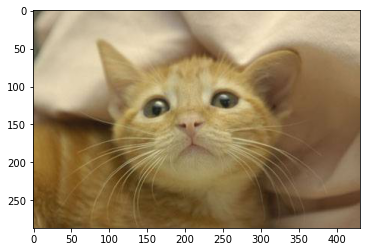

In [12]:
plt.imshow(img);

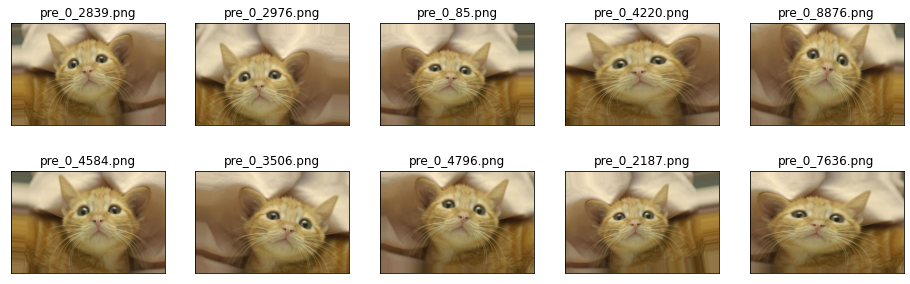

In [13]:
plt.figure(figsize=(16,5))
for i, fname in enumerate(glob('preview/*.png')):
    img = Image.open(fname)
    plt.subplot(2,5,i+1)
    plt.imshow(img), plt.title(fname.split('/')[-1]), plt.xticks([]), plt.yticks([])
plt.show()

In [14]:
aug_train_cats_dir = 'augmented/train/cats'
aug_train_dogs_dir = 'augmented/train/dogs'
if not os.path.exists('augmented'):
    os.mkdir('augmented')
    os.mkdir('augmented/train')
    os.mkdir(aug_train_cats_dir)
    os.mkdir(aug_train_dogs_dir)

In [15]:
from tqdm.notebook import tqdm
for fname in tqdm(glob(f'{old_train_cats_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=aug_train_cats_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
for fname in tqdm(glob(f'{old_train_dogs_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=aug_train_dogs_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
len(os.listdir(aug_train_cats_dir)), len(os.listdir(aug_train_dogs_dir))

(9996, 9995)

In [18]:
cat_fnames = glob(f'{aug_train_cats_dir}/*.png')
cat_fnames[:4]

['augmented/train/cats/718_0_1012.png',
 'augmented/train/cats/398_0_7987.png',
 'augmented/train/cats/844_0_7096.png',
 'augmented/train/cats/775_0_6178.png']

In [19]:
# cats_and_dogs_augmented -> image 축소/확대후 centering -> cats_and_dogs_centered
for src_dir in [aug_train_cats_dir,aug_train_dogs_dir,old_validation_cats_dir,old_validation_dogs_dir]:
    dst_dir = src_dir.split('/')[1:]            # cats_and_dogs_filtered 제거
    dst_dir = '/'.join([CENTER_DIR] + dst_dir)  # CENTER_DIR 밑에 오는 디렉토리 지정
    for fname in tqdm(glob(f'{src_dir}/*')):
        dst_fname = fname.split('/')[-1]    # 예를 들어, cat.475.jpg
        src_img = Image.open(fname)         # 사이즈가 제각각인 이미지
        dst_img = center_image(src_img)     # 150 x 150으로 centering된 이미지(pillow로 변경됨)
        dst_img.save(f'{dst_dir}/{dst_fname}')

  0%|          | 0/9996 [00:00<?, ?it/s]

  0%|          | 0/9995 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
# 파일 갯수 확인
len(os.listdir(train_cats_dir)), len(os.listdir(train_dogs_dir))

(9996, 9995)

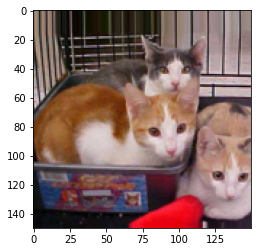

In [25]:
# 이미지 확인
img = Image.open(f'{train_cats_dir}/126_0_1289.png')
plt.imshow(img);

- Case 2) 원본 이미지 -> 150x150 -> 부풀리기

In [26]:
CENTER_DIR2 = 'case2_centered'
train_dir = f'{CENTER_DIR2}/train'
validation_dir = f'{CENTER_DIR2}/validation'
train_cats_dir = f'{CENTER_DIR2}/train/cats'
train_dogs_dir = f'{CENTER_DIR2}/train/dogs'
validation_cats_dir = f'{CENTER_DIR2}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR2}/validation/dogs'

In [27]:
if not os.path.exists(CENTER_DIR2):
    os.mkdir(CENTER_DIR2)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [28]:
aug_train_cats_dir = 'case2_augmented/train/cats'
aug_train_dogs_dir = 'case2_augmented/train/dogs'
if not os.path.exists('case2_augmented'):
    os.mkdir('case2_augmented')
    os.mkdir('case2_augmented/train')
    os.mkdir(aug_train_cats_dir)
    os.mkdir(aug_train_dogs_dir)

In [29]:
aug_train_cats_dir = 'case2_augmented/train/cats'
aug_train_dogs_dir = 'case2_augmented/train/dogs'
if not os.path.exists('case2_augmented'):
    os.mkdir('case2_augmented')
    os.mkdir('case2_augmented/train')
    os.mkdir(aug_train_cats_dir)
    os.mkdir(aug_train_dogs_dir)
# cats_and_dogs_filtered -> image 축소/확대후 centering -> cats_and_dogs_augmented
for src_dir in [old_train_cats_dir,old_train_dogs_dir,old_validation_cats_dir,old_validation_dogs_dir]:
    dst_dir = src_dir.split('/')[1:]            # cats_and_dogs_filtered 제거
    dst_dir = '/'.join([CENTER_DIR2] + dst_dir)  # CENTER_DIR 밑에 오는 디렉토리 지정
    for fname in tqdm(glob(f'{src_dir}/*')):
        dst_fname = fname.split('/')[-1]    # 예를 들어, cat.475.jpg
        src_img = Image.open(fname)         # 사이즈가 제각각인 이미지
        dst_img = center_image(src_img)     # 150 x 150으로 centering된 이미지(pillow로 변경됨)
        dst_img.save(f'{dst_dir}/{dst_fname}')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
train_cats_dir, aug_train_cats_dir

('case2_centered/train/cats', 'case2_augmented/train/cats')

In [31]:
for fname in tqdm(glob(f'{train_cats_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=aug_train_cats_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
for fname in tqdm(glob(f'{train_dogs_dir}/*.jpg')):
    img = load_img(fname)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    pre = fname.split('.')[1]
    count = 0
    for _ in train_datagen.flow(x, batch_size=1, save_to_dir=aug_train_dogs_dir, save_prefix=pre):
        count += 1
        if count >= 10:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
len(os.listdir(aug_train_cats_dir)), len(os.listdir(aug_train_dogs_dir))

(9998, 9991)

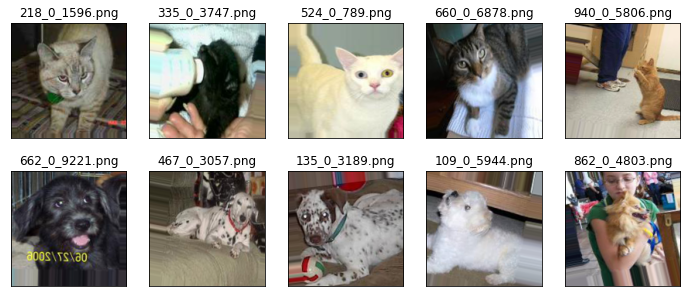

In [34]:
plt.figure(figsize=(12,5))
cat_fnames = glob(f'{aug_train_cats_dir}/*')
dog_fnames = glob(f'{aug_train_dogs_dir}/*')
for i in range(5):
    img = Image.open(cat_fnames[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img), plt.title(cat_fnames[i].split('/')[-1]), plt.xticks([]), plt.yticks([])
    img = Image.open(dog_fnames[i])
    plt.subplot(2,5,i+1+5)
    plt.imshow(img), plt.title(dog_fnames[i].split('/')[-1]), plt.xticks([]), plt.yticks([])
plt.show()